<a href="https://colab.research.google.com/github/bsong75/brendensong.github.io/blob/main/2024_0801_SMOTENC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Credit Card transactions Fraud transactions  (SMOTE methods)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
import seaborn as sns

In [4]:

# Set random seed for reproducibility
np.random.seed(42)

# Create a synthetic imbalanced dataset with categorical features
def create_imbalanced_dataset(n_samples=1000, fraud_ratio=0.05):
    """
    Create a synthetic dataset with imbalanced classes and a categorical feature

    Parameters:
    n_samples (int): Total number of samples
    fraud_ratio (float): Proportion of fraud cases

    Returns:
    pd.DataFrame: Dataset with features and target
    """
    # Calculate number of samples for each class
    n_fraud = int(n_samples * fraud_ratio)
    n_normal = n_samples - n_fraud

    # Generate normal transactions
    normal_amount = np.random.normal(loc=100, scale=50, size=n_normal)
    normal_amount = np.clip(normal_amount, 1, 1000)  # Clip to avoid negative values
    normal_frequency = np.random.poisson(lam=5, size=n_normal)
    normal_frequency = np.clip(normal_frequency, 1, 30)
    normal_distance = np.random.normal(loc=20, scale=10, size=n_normal)
    normal_distance = np.clip(normal_distance, 0, 100)

    # Generate fraud transactions
    fraud_amount = np.random.normal(loc=750, scale=200, size=n_fraud)
    fraud_amount = np.clip(fraud_amount, 1, 2000)
    fraud_frequency = np.random.poisson(lam=15, size=n_fraud)
    fraud_frequency = np.clip(fraud_frequency, 1, 40)
    fraud_distance = np.random.normal(loc=60, scale=20, size=n_fraud)
    fraud_distance = np.clip(fraud_distance, 0, 200)

    # Combine numerical features
    amount = np.concatenate([normal_amount, fraud_amount])
    frequency = np.concatenate([normal_frequency, fraud_frequency])
    distance = np.concatenate([normal_distance, fraud_distance])

    # Create categorical feature: transaction_type
    # For normal transactions, category distribution
    normal_category = np.random.choice(
        ['retail', 'online', 'recurring', 'atm'],
        size=n_normal,
        p=[0.4, 0.3, 0.2, 0.1]
    )

    # For fraud transactions, different category distribution
    fraud_category = np.random.choice(
        ['retail', 'online', 'recurring', 'atm'],
        size=n_fraud,
        p=[0.1, 0.7, 0.1, 0.1]
    )

    transaction_type = np.concatenate([normal_category, fraud_category])

    # Create target variable
    target = np.concatenate([np.zeros(n_normal), np.ones(n_fraud)])

    # Create DataFrame
    df = pd.DataFrame({
        'transaction_amount': amount,
        'transaction_frequency': frequency,
        'transaction_distance': distance,
        'transaction_type': transaction_type,
        'is_fraud': target
    })

    # Shuffle the dataset
    return df.sample(frac=1).reset_index(drop=True)

# Create the imbalanced dataset
df = create_imbalanced_dataset(n_samples=10000, fraud_ratio=0.05)


In [5]:

# Display the class distribution
print("Original class distribution:")
print(df['is_fraud'].value_counts())
print(f"Class imbalance ratio: 1:{df['is_fraud'].value_counts()[0]/df['is_fraud'].value_counts()[1]:.1f}")

# Explore the categorical feature
print("\nDistribution of transaction types:")
print(df['transaction_type'].value_counts())

print("\nTransaction type distribution by fraud status:")
print(pd.crosstab(df['is_fraud'], df['transaction_type'], normalize='index'))

# Split features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check the distribution in train set
print("\nTraining set class distribution:")
print(y_train.value_counts())

# Identify the categorical feature indices for SMOTENC
categorical_features = [X_train.columns.get_loc('transaction_type')]
print(f"\nCategorical feature index: {categorical_features}")

# Apply SMOTENC to balance the dataset
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# Check the distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Check the categorical distribution after SMOTE
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
print("\nTransaction type distribution after SMOTE:")
print(pd.crosstab(y_train_resampled, X_train_resampled_df['transaction_type'], normalize='index'))

# Create preprocessing pipeline
# Preprocessing with StandardScaler for numerical features and OneHotEncoder for categorical features
numeric_features = ['transaction_amount', 'transaction_frequency', 'transaction_distance']
categorical_features_names = ['transaction_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features_names)
    ])

Original class distribution:
is_fraud
0.0    9500
1.0     500
Name: count, dtype: int64
Class imbalance ratio: 1:19.0

Distribution of transaction types:
transaction_type
retail       3861
online       3158
recurring    1988
atm           993
Name: count, dtype: int64

Transaction type distribution by fraud status:
transaction_type       atm    online  recurring    retail
is_fraud                                                 
0.0               0.100316  0.293368   0.204526  0.401789
1.0               0.080000  0.742000   0.090000  0.088000

Training set class distribution:
is_fraud
0.0    6650
1.0     350
Name: count, dtype: int64

Categorical feature index: [3]

Class distribution after SMOTE:
is_fraud
0.0    6650
1.0    6650
Name: count, dtype: int64

Transaction type distribution after SMOTE:
transaction_type       atm    online  recurring    retail
is_fraud                                                 
0.0               0.097594  0.294286   0.208722  0.399398
1.0             


Logistic Regression Results:
Accuracy: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Confusion Matrix:
[[2850    0]
 [   0  150]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2850
         1.0       1.00      1.00      1.00       150

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000


Random Forest Results:
Accuracy: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Confusion Matrix:
[[2850    0]
 [   0  150]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2850
         1.0       1.00      1.00      1.00       150

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000


SVM Results:
Accuracy: 1.0000
F1 Score: 1.0000
ROC 

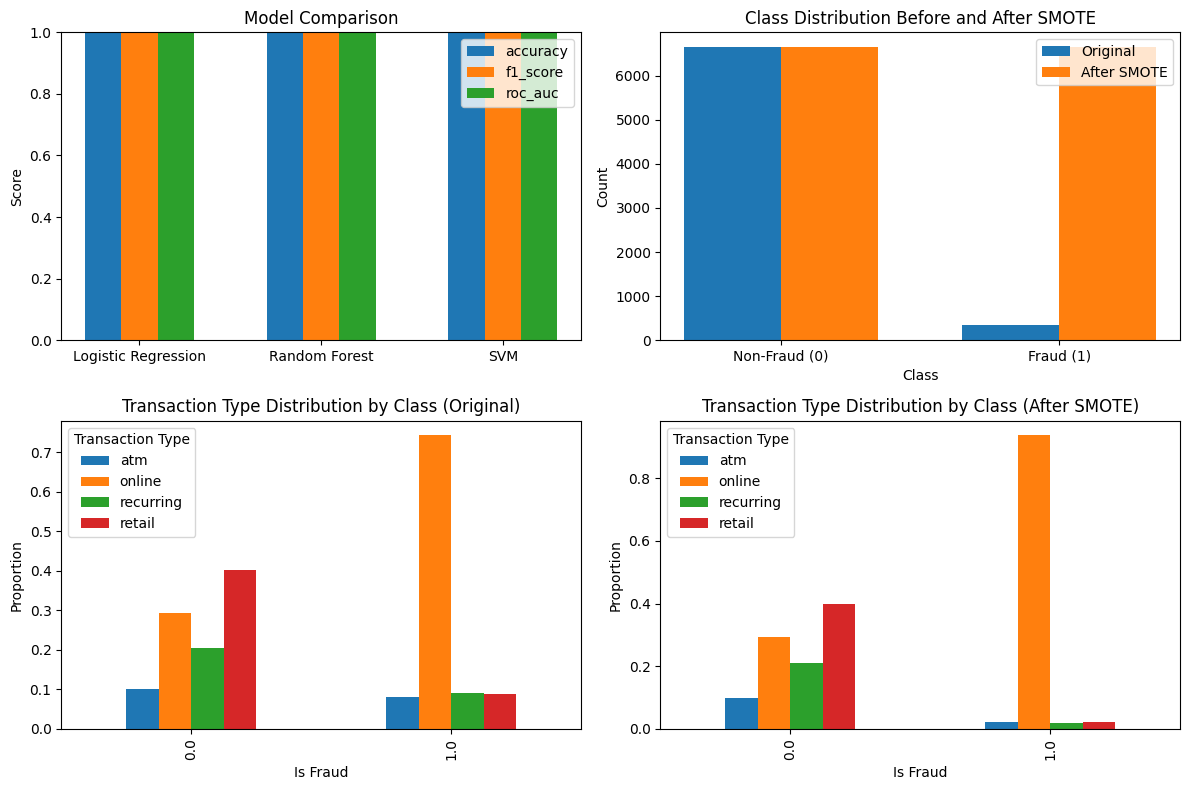

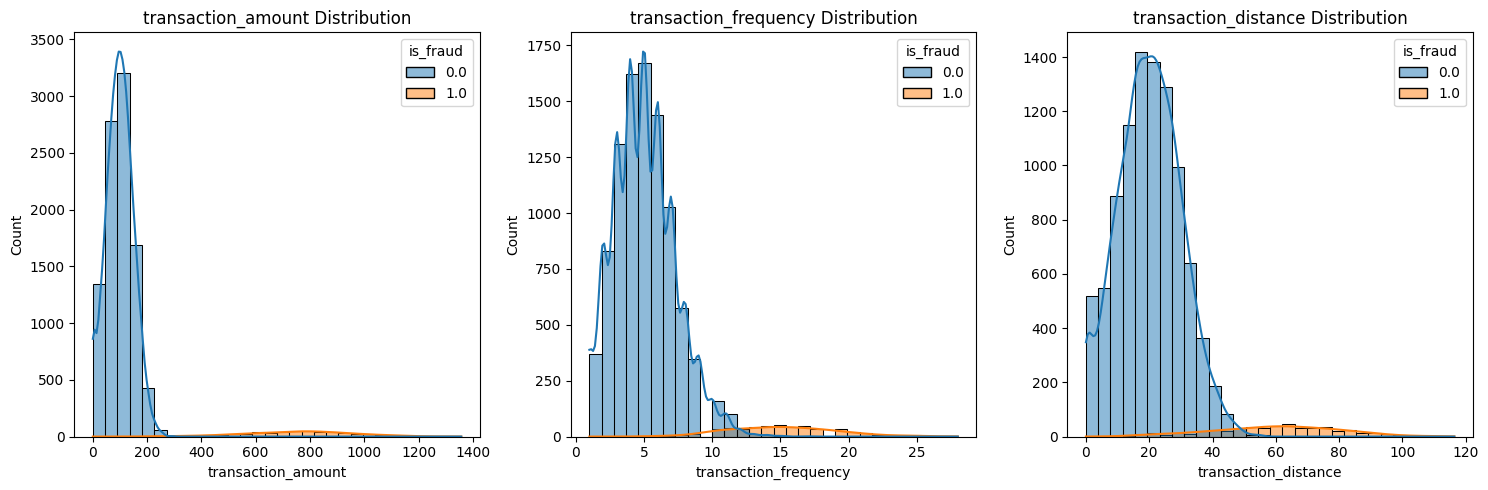


Random Forest Results:
Accuracy: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Confusion Matrix:
[[2850    0]
 [   0  150]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2850
         1.0       1.00      1.00      1.00       150

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



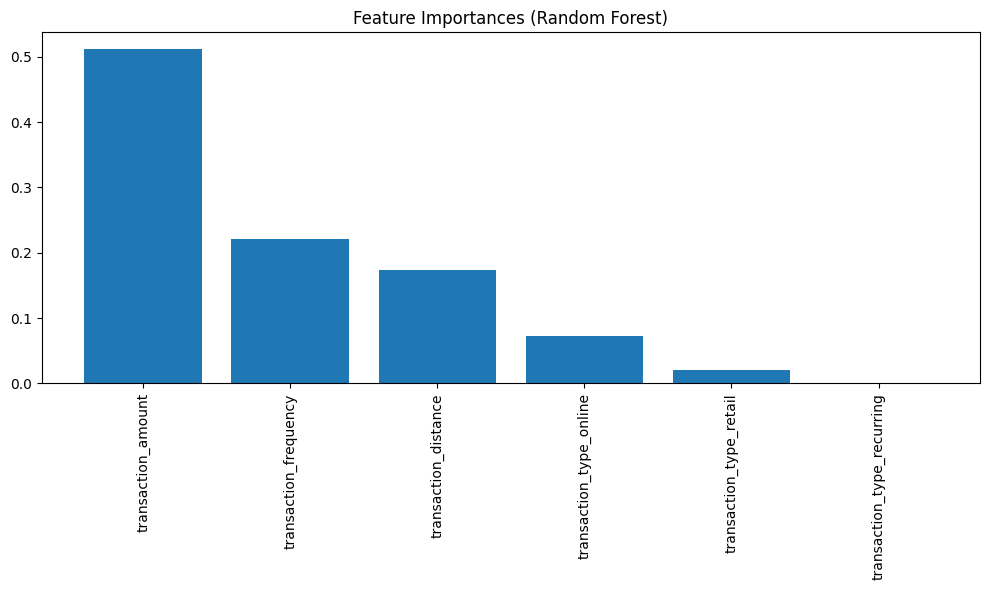

In [6]:
# Function to evaluate a model with a preprocessing pipeline
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Train and evaluate a classification model with preprocessing

    Parameters:
    model: The model to evaluate
    X_train, y_train: Training data
    X_test, y_test: Test data
    model_name (str): Name of the model for reporting

    Returns:
    dict: Performance metrics
    """
    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC AUC if probability predictions are available
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc:
        print(f"ROC AUC: {auc:.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Return metrics for comparison
    return {
        'model': model_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': auc,
        'pipeline': pipeline
    }

# Define the models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True)
}

# Evaluate each model
results = []
for name, model in models.items():
    result = evaluate_model(model, X_train_resampled, y_train_resampled,
                           X_test, y_test, name)
    results.append({k: v for k, v in result.items() if k != 'pipeline'})

# Compare model performance
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Find the best model based on F1 score
best_model_idx = results_df['f1_score'].idxmax()
best_model = results_df.iloc[best_model_idx]['model']
print(f"\nBest model based on F1 score: {best_model}")

# Visualize the results
plt.figure(figsize=(12, 8))

# Plot comparison of metrics
metrics = ['accuracy', 'f1_score', 'roc_auc']
plt.subplot(2, 2, 1)
for metric in metrics:
    plt.bar([i + 0.2*metrics.index(metric) for i in range(len(results))],
            results_df[metric], width=0.2, label=metric)

plt.xticks([i + 0.2 for i in range(len(results))], results_df['model'])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Comparison')
plt.legend()

# Plot class distribution before and after SMOTE
plt.subplot(2, 2, 2)
original_counts = y_train.value_counts()
resampled_counts = pd.Series(y_train_resampled).value_counts()

labels = ['Non-Fraud (0)', 'Fraud (1)']
x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, [original_counts[0], original_counts[1]], width, label='Original')
plt.bar(x + width/2, [resampled_counts[0], resampled_counts[1]], width, label='After SMOTE')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Before and After SMOTE')
plt.xticks(x, labels)
plt.legend()

# Plot categorical feature distribution
plt.subplot(2, 2, 3)
cat_original = pd.crosstab(df['is_fraud'], df['transaction_type'], normalize='index')
cat_original.plot(kind='bar', ax=plt.gca())
plt.title('Transaction Type Distribution by Class (Original)')
plt.xlabel('Is Fraud')
plt.ylabel('Proportion')
plt.legend(title='Transaction Type')

# Plot categorical feature distribution after SMOTE
plt.subplot(2, 2, 4)
cat_resampled = pd.crosstab(y_train_resampled, X_train_resampled_df['transaction_type'], normalize='index')
cat_resampled.plot(kind='bar', ax=plt.gca())
plt.title('Transaction Type Distribution by Class (After SMOTE)')
plt.xlabel('Is Fraud')
plt.ylabel('Proportion')
plt.legend(title='Transaction Type')

plt.tight_layout()
plt.show()

# Additional visualization: Feature distributions for fraud vs non-fraud
plt.figure(figsize=(15, 5))
numeric_features = ['transaction_amount', 'transaction_frequency', 'transaction_distance']

for i, feature in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=feature, hue='is_fraud', bins=30, kde=True)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Feature importance (for Random Forest)
if 'Random Forest' in models:
    # Get the Random Forest pipeline
    rf_result = next(result for name, model in models.items()
                    if name == 'Random Forest'
                    for result in [evaluate_model(model, X_train_resampled, y_train_resampled,
                                                X_test, y_test, name)])

    rf_pipeline = rf_result['pipeline']
    rf_model = rf_pipeline.named_steps['classifier']

    # Get the preprocessor
    preprocessor = rf_pipeline.named_steps['preprocessor']

    # Get feature names after preprocessing
    ohe = preprocessor.named_transformers_['cat']
    feature_names = (
        numeric_features +
        list(ohe.get_feature_names_out(categorical_features_names))
    )

    # Get feature importances
    importances = rf_model.feature_importances_

    # Sort feature importances
    indices = np.argsort(importances)[::-1]

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances (Random Forest)')
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()